In [98]:
import numpy as np
import tensorflow as tf
import os
import torch
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import matplotlib.pyplot as plt

##### Step 1. Use one of the deep learning frameworks (Pytorch, Tensorflow, Keras, ...) and load the pre-trained AlexNet model. Input these 156 images to the pre-trained AlexNet model and extract feature maps/activations from Conv 1, 2, 3, 4, 5, fc6, and fc7 layers. Vectorize the activations corresponding to each image. You should have a vector of activations per image per layer mentioned above. (20 points)

In [2]:
model = models.alexnet(weights='DEFAULT')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
imgOutputs = []
path = "./Image Set"
for file in os.listdir(path):
    img=os.path.join(path,file)

    model = create_feature_extractor(model, 
                    {"features.0":"conv1","features.3":"conv2","features.6":"conv3","features.8":"conv4","features.10":"conv5",
                    "classifier.1":"fc6","classifier.4":"fc7"})

    input_image = Image.open(img)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        out = model(input_batch)

    for key in out:
        out[key]=out[key].view(out[key].size(0), -1)

    imgOutputs.append(out)

##### Step 2. Create a representational dissimilarity matrix (RDM) which is 156 x156 matrix, each row and column in this matrix is indexed by one of the images in the image set and each element in the matrix is the Euclidean distance between the activation vectors of the corresponding images you extracted in Step 1. (30 points)

In [4]:
def generateRDM(layer):
    RDM = np.zeros((len(imgOutputs),len(imgOutputs)))
    for i,img1 in enumerate(imgOutputs):
        for j,img2 in enumerate(imgOutputs):
            RDM[i,j] = tf.norm(img1[layer]-img2[layer])
    return RDM


In [5]:
RDMS = { layer:generateRDM(layer) for layer in imgOutputs[0] }

##### Step 3. Plot the RDM for each layer (Conv 1, 2, 3, 4, 5, fc6, fc7), and their corresponding multidimensional scaling (MDS) visualization in 2 Dimension. The class labels you should use for the MDS plotting includes images 1 to 28 are Animals, 29-64 are Objects, 65 to 100 are scenes, 101 to 124 are human activities, 125 to 156 are faces. (30 points)

In [59]:
from sklearn.manifold import MDS
def generateMDS(rdm):
    mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
    mdsFit = mds.fit_transform(rdm)
    return mdsFit

In [60]:
MDS = { layer:generateMDS(RDMS[layer]) for layer in RDMS }

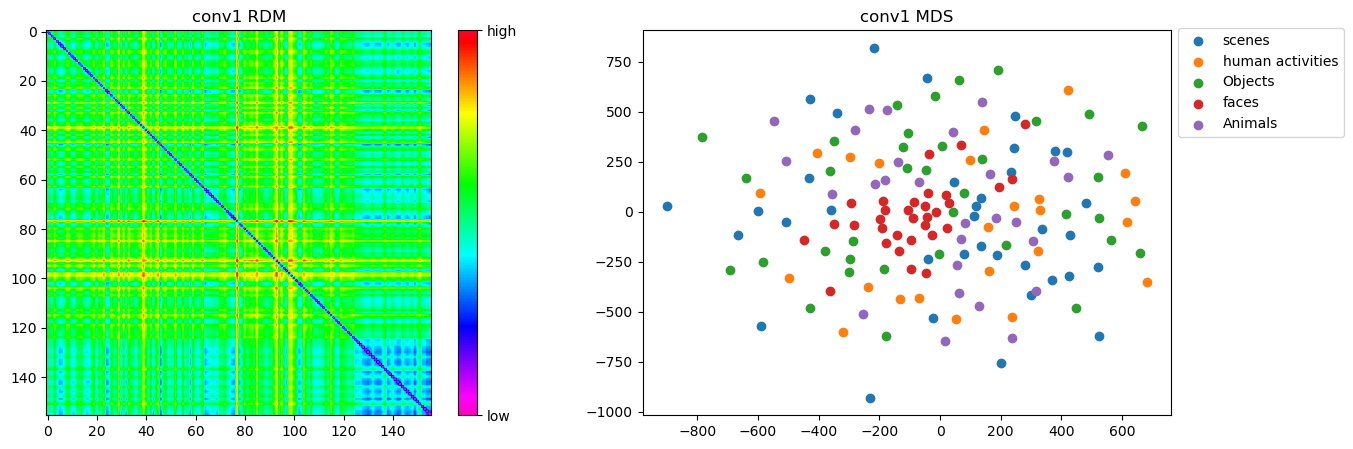

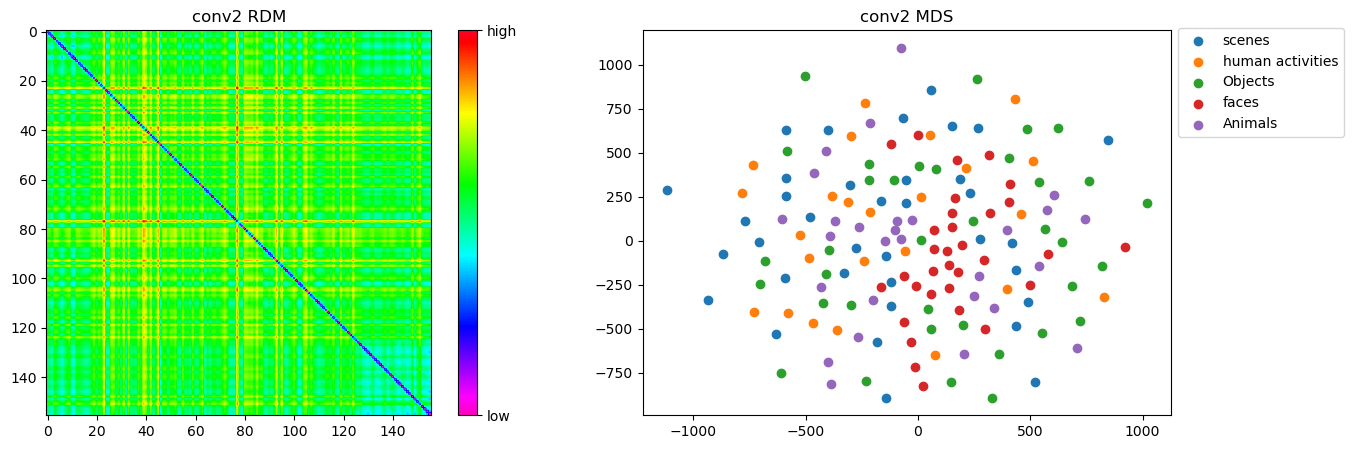

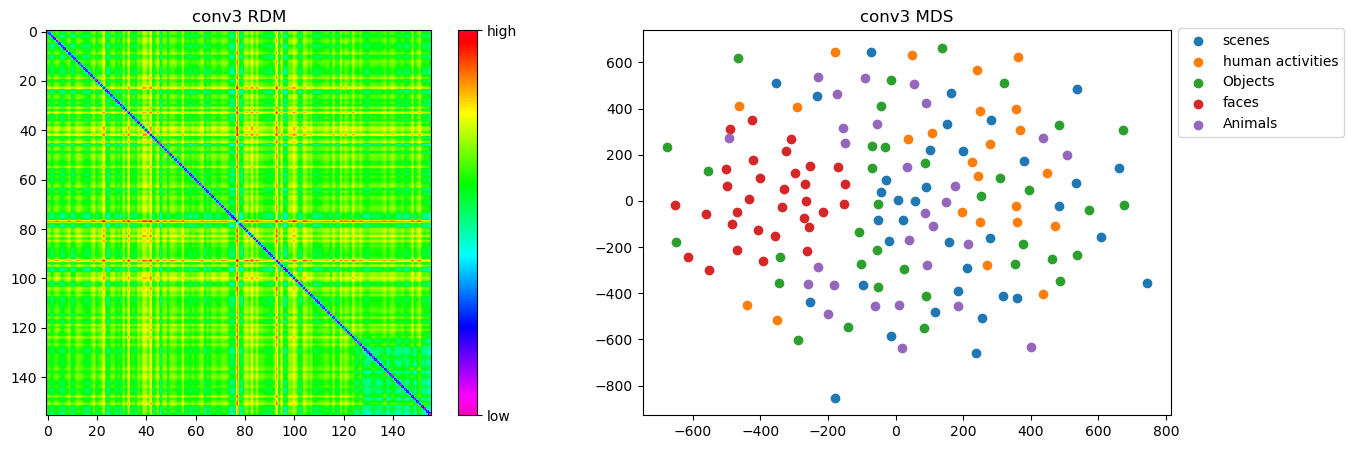

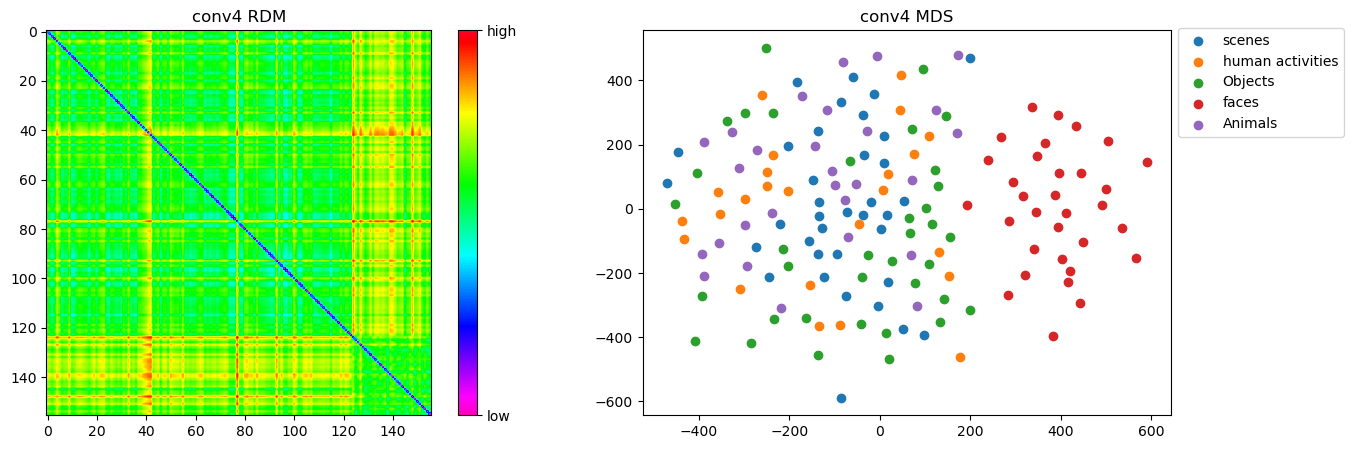

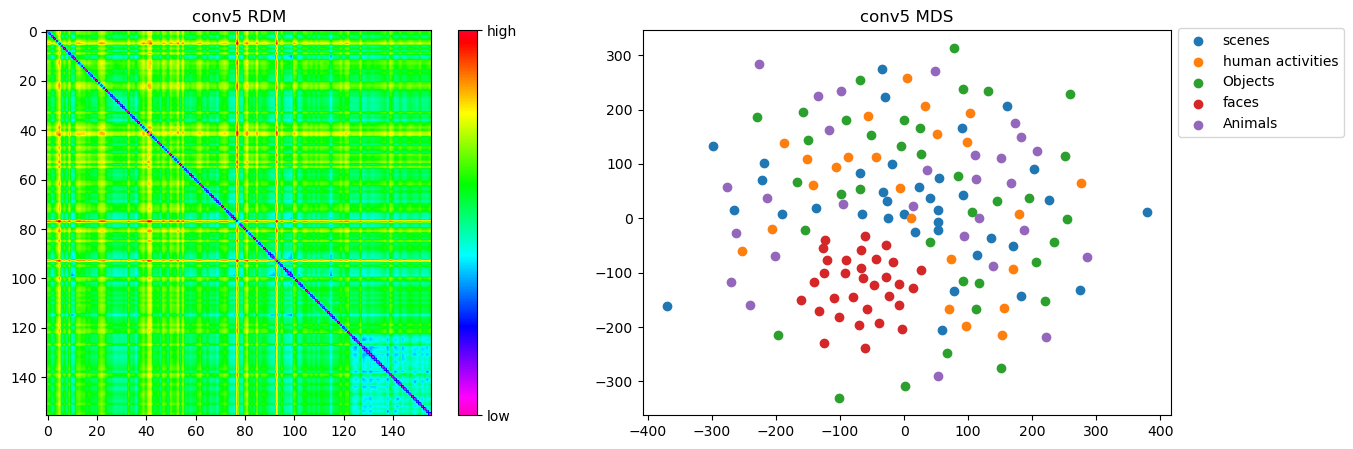

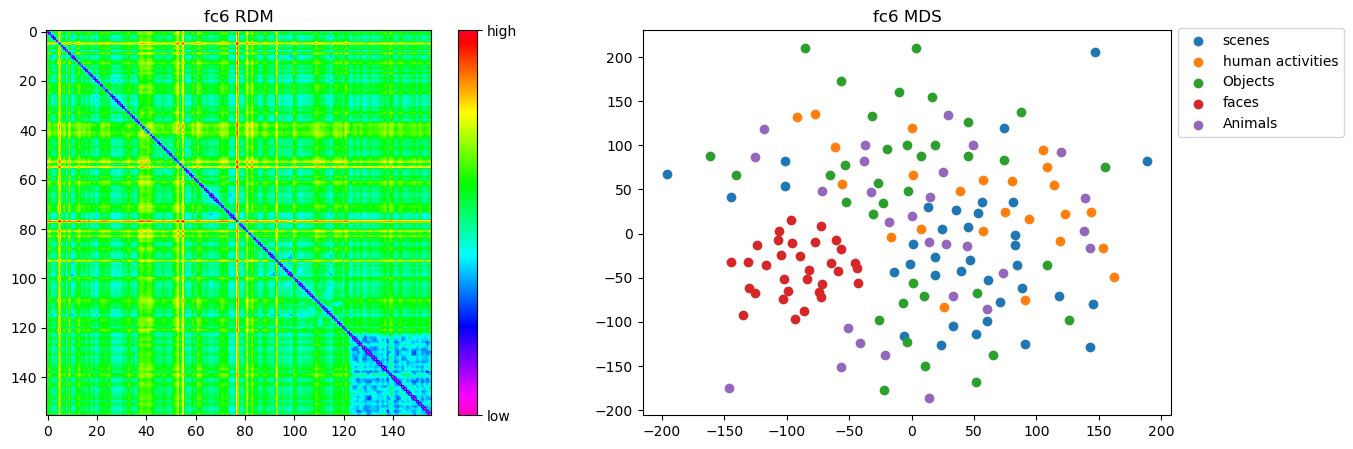

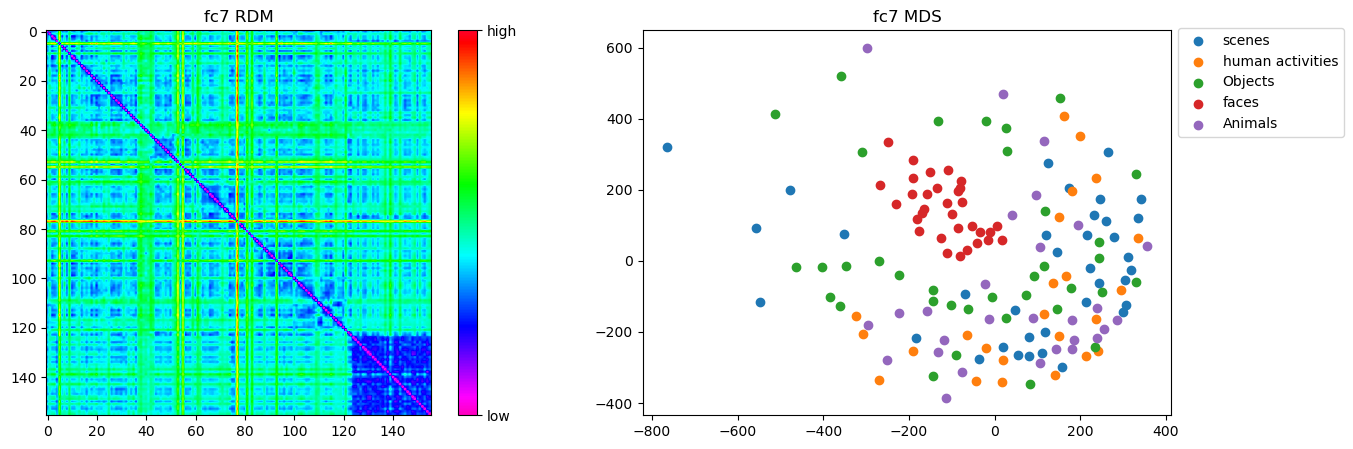

In [95]:
classLabels = ["Animals" if i < 28 else "Objects" if i < 64 else "scenes" if i < 100 else "human activities" if i < 124 else "faces" for i in range(len(imgOutputs))]

for layer in RDMS:
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot(1,2,1)
    plt.imshow(RDMS[layer], cmap='gist_rainbow_r')
    plt.title(f'{layer} RDM')
    cbar=plt.colorbar()
    cbar.set_ticks([0,max(RDMS[layer].flatten())])
    cbar.set_ticklabels(['low','high'])
    plt.subplot(1,2,2)
    for label in set(classLabels):
        i = [j for j,cls in enumerate(classLabels) if cls == label]
        plt.scatter(MDS[layer][i,0], MDS[layer][i,1], label=label)
    plt.title(f'{layer} MDS')
    plt.legend(bbox_to_anchor=(1,1.024))
plt.show()

##### Please write a short report presenting and discussing the results of this assignment. (20 points)

please see attached pdf